In [4]:
import torch
import torch.nn as nn

from torch.optim import Adam
from torch.distributions.uniform import Uniform
from torch.utils.data import TensorDataset, DataLoader

import lightning as L

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

* First, using basic math

Training data:
    
    Troll 2 is great!
    Gymkata is great!

In [6]:
inputs = torch.tensor([[1.,0.,0.,0.],
                      [0.,1.,0.,0.],
                      [0.,0.,1.,0.],
                      [0.,0.,0.,1.]])

labels = torch.tensor([[0.,1.,0.,0.],
                      [0.,0.,1.,0.],
                      [0.,0.,0.,1.],
                      [0.,1.,0.,0.]])

dataset = TensorDataset(inputs, labels)
dataloader = DataLoader(dataset)

In [8]:
class WordEmbeddScratch(L.LightningModule):
    def __init__(self):
        super().__init__()
        # Using uniform distribution from -0.5 to 0.5
        min = -0.5
        max = 0.5

        self.input1_w1 = nn.Parameter(Uniform(min, max).sample())
        self.input1_w2 = nn.Parameter(Uniform(min, max).sample())
        self.input2_w1 = nn.Parameter(Uniform(min, max).sample())
        self.input2_w2 = nn.Parameter(Uniform(min, max).sample())
        self.input3_w1 = nn.Parameter(Uniform(min, max).sample())
        self.input3_w2 = nn.Parameter(Uniform(min, max).sample())
        self.input4_w1 = nn.Parameter(Uniform(min, max).sample())
        self.input4_w2 = nn.Parameter(Uniform(min, max).sample())

        self.output1_w1 = nn.Parameter(Uniform(min, max).sample())
        self.output1_w2 = nn.Parameter(Uniform(min, max).sample())
        self.output2_w1 = nn.Parameter(Uniform(min, max).sample())
        self.output2_w2 = nn.Parameter(Uniform(min, max).sample())
        self.output3_w1 = nn.Parameter(Uniform(min, max).sample())
        self.output3_w2 = nn.Parameter(Uniform(min, max).sample())
        self.output4_w1 = nn.Parameter(Uniform(min, max).sample())
        self.output4_w2 = nn.Parameter(Uniform(min, max).sample())        

        self.loss = nn.CrossEntropyLoss()
    
    def forward(self, input):
        input = input[0]

        input_to_top_hidden = ((input[0]*self.input1_w1)+
                               (input[1]*self.input2_w1)+
                               (input[2]*self.input3_w1)+
                               (input[3]*self.input4_w1))

        input_to_bottom_hidden = ((input[0]*self.input1_w2)+
                                  (input[1]*self.input2_w2)+
                                  (input[2]*self.input3_w2)+
                                  (input[3]*self.input4_w2))

        output1 = ((input_to_top_hidden*self.output1_w1)+
                  (input_to_bottom_hidden*self.output1_w2))
        output2 = ((input_to_top_hidden*self.output2_w1)+
                  (input_to_bottom_hidden*self.output2_w2))
        output3 = ((input_to_top_hidden*self.output3_w1)+
                  (input_to_bottom_hidden*self.output3_w2))
        output4 = ((input_to_top_hidden*self.output4_w1)+
                  (input_to_bottom_hidden*self.output4_w2))

        output_presoftmax = torch.stack([output1, output2, output3, output4])

        return output_presoftmax

    def configure_optimizers(self):
        return Adam(self.parameters(), lr = 0.1)

    def training_step(self, batch, batch_idx):
        input_i, label_i = batch
        output_i = self.forward(input_i)
        loss = self.loss(output_i, label_i[0])

        return loss

In [9]:
model_scratch = WordEmbeddScratch()

print("Before optimization:")
for name, param in model_scratch.named_parameters():
    print(name, param.data)

Before optimization:
input1_w1 tensor(0.0447)
input1_w2 tensor(-0.2590)
input2_w1 tensor(0.4779)
input2_w2 tensor(-0.4667)
input3_w1 tensor(0.1369)
input3_w2 tensor(0.4751)
input4_w1 tensor(0.3106)
input4_w2 tensor(0.3056)
output1_w1 tensor(-0.4784)
output1_w2 tensor(0.1881)
output2_w1 tensor(0.4886)
output2_w2 tensor(-0.1570)
output3_w1 tensor(0.1079)
output3_w2 tensor(-0.1989)
output4_w1 tensor(0.4478)
output4_w2 tensor(0.0882)


In [10]:
data = {
    "w1" : [model_scratch.input1_w1.item(),
           model_scratch.input2_w1.item(),
           model_scratch.input3_w1.item(),
           model_scratch.input4_w1.item()] , 
    "w2" : [model_scratch.input1_w2.item(),
           model_scratch.input2_w2.item(),
           model_scratch.input3_w2.item(),
           model_scratch.input4_w2.item()] , 
    "word" : ["Troll2", "is", "great", "Gymkata"] , 
    "input" : ["input1", "input2", "input3", "input4"]
}
df = pd.DataFrame(data)
df

,w1,w2,word,input
0,0.044664,-0.258994,Troll2,input1
1,0.477857,-0.466748,is,input2
2,0.136899,0.475128,great,input3
3,0.310561,0.305626,Gymkata,input4


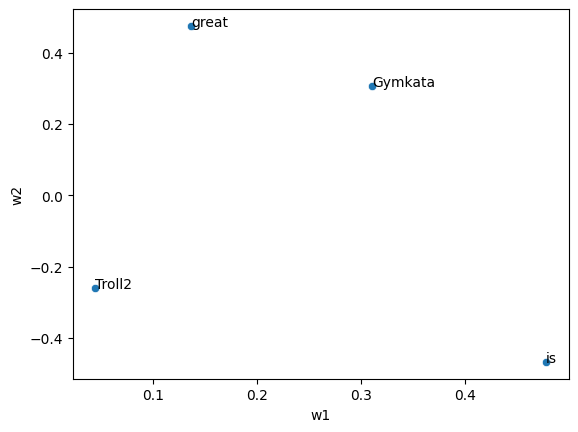

In [14]:
sns.scatterplot(data = df, x = "w1", y = "w2")
for i in range(4):
    plt.text(df.w1[i], df.w2[i], df.word[i])

In [15]:
trainer = L.Trainer(max_epochs=100)
trainer.fit(model_scratch, train_dataloaders=dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params
--------------------------------------------------
0 | loss         | CrossEntropyLoss | 0     
  | other params | n/a              | 16    
--------------------------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)
C:\Users\Pratham\AppData\Local\Programs\Python\Python310\lib\si

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=100` reached.


In [16]:
data = {
    "w1" : [model_scratch.input1_w1.item(),
           model_scratch.input2_w1.item(),
           model_scratch.input3_w1.item(),
           model_scratch.input4_w1.item()] , 
    "w2" : [model_scratch.input1_w2.item(),
           model_scratch.input2_w2.item(),
           model_scratch.input3_w2.item(),
           model_scratch.input4_w2.item()] , 
    "word" : ["Troll2", "is", "great", "Gymkata"] , 
    "input" : ["input1", "input2", "input3", "input4"]
}
df = pd.DataFrame(data)
df

,w1,w2,word,input
0,2.278541,-1.281793,Troll2,input1
1,-1.360128,-3.110084,is,input2
2,1.132472,2.778224,great,input3
3,2.257237,-1.146011,Gymkata,input4


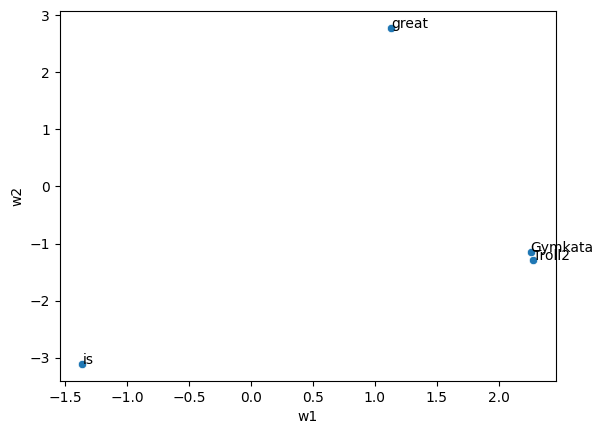

In [17]:
sns.scatterplot(data = df, x = "w1", y = "w2")
for i in range(4):
    plt.text(df.w1[i], df.w2[i], df.word[i])

In [18]:
softmax = nn.Softmax(dim=0)

print(torch.round(softmax(model_scratch(torch.tensor([[1.,0.,0.,0.]]))), decimals=2))

tensor([0., 1., 0., 0.], grad_fn=<RoundBackward1>)


* Using nn.Linear()

In [19]:
class WordEmbeddLinear(L.LightningModule):
    def __init__(self):
        super().__init__()

        self.input_to_hidden = nn.Linear(in_features=4, out_features=2, bias=False)
        self.hidden_to_output = nn.Linear(in_features=2, out_features=4, bias=False)

        self.loss = nn.CrossEntropyLoss()

    def forward(self, input):
        hidden = self.input_to_hidden(input)
        output_values = self.hidden_to_output(hidden)

        return output_values

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=0.1)

    def training_step(self, batch, batch_idx):
        input_i, label_i = batch
        output_i = self.forward(input_i)
        loss = self.loss(output_i, label_i)

        return loss

In [24]:
model_linear = WordEmbeddLinear()

data = {
    "w1": model_linear.input_to_hidden.weight.detach()[0].numpy(),
    "w2": model_linear.input_to_hidden.weight.detach()[1].numpy(),
    "token": ["Troll2", "is", "great", "Gymkata"],
    "input" : ["input1", "input2", "input3", "input4"]
}
df = pd.DataFrame(data)
df

,w1,w2,token,input
0,-0.054960,-0.346771,Troll2,input1
1,-0.364397,-0.283785,is,input2
2,-0.430642,0.248248,great,input3
3,0.472206,-0.196625,Gymkata,input4


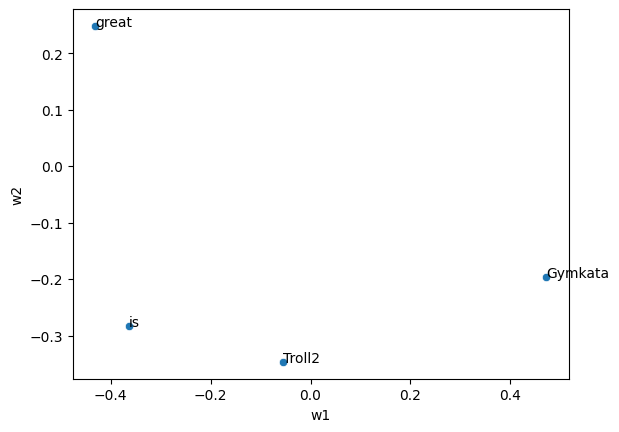

In [26]:
sns.scatterplot(data = df, x = "w1", y = "w2")
for i in range(4):
    plt.text(df.w1[i], df.w2[i], df.token[i])

In [27]:
trainer = L.Trainer(max_epochs=100)
trainer.fit(model_linear, train_dataloaders=dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type             | Params
------------------------------------------------------
0 | input_to_hidden  | Linear           | 8     
1 | hidden_to_output | Linear           | 8     
2 | loss             | CrossEntropyLoss | 0     
------------------------------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)
C:\Users\Pratham\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
C:\Users\Pratham\AppData\Local\P

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=100` reached.


In [28]:
data = {
    "w1": model_linear.input_to_hidden.weight.detach()[0].numpy(),
    "w2": model_linear.input_to_hidden.weight.detach()[1].numpy(),
    "token": ["Troll2", "is", "great", "Gymkata"],
    "input" : ["input1", "input2", "input3", "input4"]
}
df = pd.DataFrame(data)
df

,w1,w2,token,input
0,0.799310,-2.161201,Troll2,input1
1,-2.843625,-0.582257,is,input2
2,-0.697628,2.817682,great,input3
3,0.738656,-2.235638,Gymkata,input4


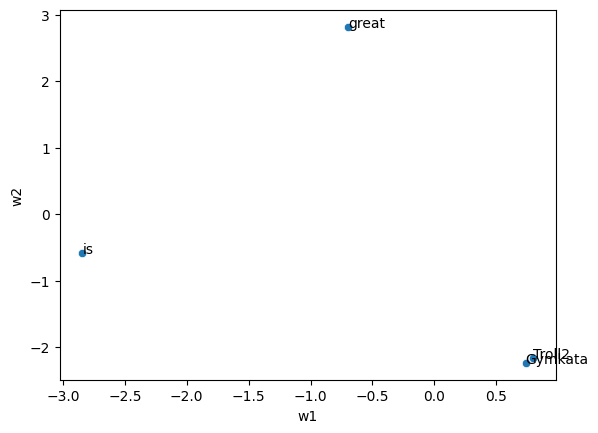

In [29]:
sns.scatterplot(data = df, x = "w1", y = "w2")
for i in range(4):
    plt.text(df.w1[i], df.w2[i], df.token[i])

* Loading and using pretrained embedding

In [30]:
model_linear.input_to_hidden.weight

Parameter containing:
tensor([[ 0.7993, -2.8436, -0.6976,  0.7387],
        [-2.1612, -0.5823,  2.8177, -2.2356]], requires_grad=True)

In [31]:
word_embeddings = nn.Embedding.from_pretrained(model_linear.input_to_hidden.weight.T)

word_embeddings.weight

Parameter containing:
tensor([[ 0.7993, -2.1612],
        [-2.8436, -0.5823],
        [-0.6976,  2.8177],
        [ 0.7387, -2.2356]])

In [32]:
word_embeddings(torch.tensor(0))

tensor([ 0.7993, -2.1612])

In [33]:
vocab = {'Troll2': 0,
         'is': 1,
         'great': 2,
         'Gymkata': 3}

word_embeddings(torch.tensor(vocab['Troll2']))

tensor([ 0.7993, -2.1612])